In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import operator
from bisect import bisect
%matplotlib inline

In [72]:
class TSP(object):
    def __init__(self,start=1,dissipation=.2,tolerance=.2,alpha=1.0,beta=1.0,explore=1.0):
        #inputs
        self.dissipation=dissipation
        self.explore=explore
        self.tolerance=tolerance
        self.alpha=alpha
        self.beta=beta
        self.start=start
        self.step=0
        
        #setup
        self.history_d={} #holds decisions about node order
        self.history_k={}
        self.history_s={}
        self.tsp=self.init_tsp()
        #self.tsp=tsp_single()
        
        #Tracking - last[type][element][node history]
        ##type - p, dist, score, route, dec
        ##element - edge, edge, step, obj, none
        self.last={'p':{},'dist':{},'score':{},'route':{},'dec':{}}
        for e in self.tsp.edges():
            self.last['p'][e]=[]
            self.last['dist'][e]=[]
        for i in xrange(self.tsp.number_of_nodes()-1):
            self.last['route'][i]=[]
        self.last['score'][0]=[]
        self.last['dec'][0]=[] #zero is placeholder
        
        self.d=[int(self.start)]
        #self.d=[]
        self.d_change=[]
        self.history_d[self.step]=list(self.d)
        self.state=self.init_graph(self.tsp)
        self.history_s[self.step]=self.state.copy()
        self.k=self.init_k(self.state)
        #self.last_solution={}
        
        
    
    def init_tsp(self):
        tsp=nx.DiGraph()
        tsp.add_edge(1,2,dist=1.0)
        tsp.add_edge(2,1,dist=1.0)
        tsp.add_edge(1,3,dist=1.0)
        tsp.add_edge(3,1,dist=1.0)        
        tsp.add_edge(1,4,dist=2.0)
        tsp.add_edge(4,1,dist=2.0)
        tsp.add_edge(2,3,dist=3.0)
        tsp.add_edge(3,2,dist=3.0)
        tsp.add_edge(2,4,dist=4.0)
        tsp.add_edge(4,2,dist=4.0)
        tsp.add_edge(3,4,dist=2.0)
        tsp.add_edge(4,3,dist=2.0)
        
        #start node
        tsp.add_node(0)
        for n in tsp.nodes():
            if n!=0:
                tsp.add_edge(0,n,dist=0.0)
                
        
        return tsp
        
    def init_graph(self,tsp):
        g=tsp.copy()
        for u,v in g.edges():
            g[u][v]['p']=0.5
            g[u][v]['dist']=0.0
            
        #initialize nodes

        #print g.edges(data=True)

        return g

    def init_k(self,g):
        k=nx.DiGraph()
        last_visited={}
        
        #k for edge data
        for u,v,d in g.edges(data=True):
            last_visited[(u,v)]={}
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,label=(u,v),p=float(d['p']),step=self.step)
            self.last['p'][(u,v)].append(n_label)
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,label=(u,v),dist=float(d['dist']),step=self.step)
            self.last['dist'][(u,v)].append(n_label)
            
        #k for decision
        n_label=k.number_of_nodes()+1
        k.add_node(n_label,label='decision', d=list(self.d), step=self.step)
        self.last['dec'][0].append(n_label)
        
        self.history_k[self.step]=k.copy()
        self.step+=1

        return k #,last_visited
    
    def walk(self):
        #initialize
        g=self.state.copy()
        tsp=self.tsp.copy()
        #tabu=[int(self.start)]
        if not self.d:
            tabu=[random.choice(g.nodes())]
        else:
            tabu=[self.d[0]]
            
        for i in xrange(g.number_of_nodes()-1):
            #get pheromone list
            n_l=[]
            p_l=[]
            h_l=[]
            dec_point=False #checks if this step is affected by a decision
            for n in g.nodes():
                if n not in tabu:
                    n_l.append(n)
                    p_l.append(g[tabu[-1]][n]['p'])
                    
                    if g[tabu[-1]][n]['p']==0.0: #Part of a decision process
                        dec_point=True
                    
                    
                    if g[tabu[-1]][n]['dist']==0.0:
                        h_l.append(self.explore) #10.0
                    else:
                        h_l.append(1.0/g[tabu[-1]][n]['dist'])
                    
            c_l=np.power(p_l,self.alpha)*np.power(h_l,self.beta)
            n_index=self.make_decision(c_l)
            new_n=n_l[n_index]
                
            #update k with edge from tau and dist to edge selection
            n_label=self.k.number_of_nodes()+1
            
            #label is edge number in solution, e is edge added
            self.k.add_node(n_label,label='selection',i=i,e=(tabu[-1],new_n),step=self.step)
            self.last['route'][i].append(n_label)
            
            for e_i in xrange(len(tabu)-1): #iterate through added edges
                #add constraining 
                last=self.last['route'][e_i][-1]
                self.k.add_edge(last,n_label,step=self.step,t=1)
            
            #if influenced by decision, edge from decision not other edge info
            if (dec_point or (len(n_l)==1 and len(self.d)==self.tsp.number_of_nodes())):
                #only edge from decision
                self.k.add_edge(self.last['dec'][0][-1],n_label,step=self.step, t=1)
                
            else:
                for n in n_l: #g.nodes():
                    #if n not in tabu: #only non tabu
                    if n != tabu[-1]: #no self-edge
                        e=(tabu[-1],n)
                        if (e[0],e[1]) not in self.tsp.edges(): #self.last_visited.keys():
                            e=(e[1],e[0])

                        self.k.add_edge(self.last['p'][e][-1],n_label,step=self.step, t=2)
                        self.k.add_edge(self.last['dist'][e][-1],n_label,step=self.step, t=2)
                    

                
            #append new node
            tabu.append(new_n)

        score=0.0
        e_r=[tuple(tabu[i:i+2]) for i in xrange(0,len(tabu), 1)]
        del e_r[-1]

        for e in e_r:
            score+=float(tsp[e[0]][e[1]]['dist'])

        return tuple(tabu), score

    def update_edges(self,route,score):
        g_t=self.state.copy()
        g=self.state.copy()
        p=float(self.dissipation)
        tsp=self.tsp.copy()
        
        #print 'before', g_t.edges(data=True)
        #print 'reduction', p
        
        #update k with rout
        #n_label=self.k.number_of_nodes()+1
        #self.k.add_node(n_label,label=route,step=self.step)
        #self.last_solution['route']=n_label
        
        # k edges from tsp edge info to route - now handled in walk
        #for e in self.last_visited:
            #self.k.add_edge(self.last_visited[e]['p'],n_label,step=self.step)
            #self.k.add_edge(self.last_visited[e]['dist'],n_label,step=self.step)
            
        
        e_r=[tuple(route[i:i+2]) for i in xrange(0,len(route), 1)]
        del e_r[-1]
        
        #update distances
        for e in e_r:
            sel_index=e_r.index(e)
            #check ordering
            if (e[0],e[1]) not in self.tsp.edges():
                e=(e[1],e[0])
            
            #update dist in k
            if g_t[e[0]][e[1]]['dist']==0.0:
                dist=float(tsp[e[0]][e[1]]['dist'])
                g_t[e[0]][e[1]]['dist']=dist
                
                #update k for changed distance
                n_label=self.k.number_of_nodes()+1
                last_n=self.last['dist'][(e[0],e[1])][-1]
                self.k.add_node(n_label,label=(e[0],e[1]),dist=float(dist),step=self.step)
                self.k.add_edge(last_n,n_label,step=self.step,t=2)
                self.k.add_edge(self.last['route'][sel_index][-1],n_label,step=self.step,t=1)
                
                self.last['dist'][(e[0],e[1])].append(n_label)
                

        #add k for score
        n_label=self.k.number_of_nodes()+1
        self.k.add_node(n_label,label='score',score=score,step=self.step)
        
        #add k from route selections to score
        for sel,n_list in self.last['route'].iteritems():
                self.k.add_edge(n_list[-1],n_label,step=self.step,t=1)
        
        self.last['score'][0].append(n_label)
        
        t_update=1.0/score
        for u,v,d in g_t.edges(data=True):
            #update pheromone
            g_t[u][v]['p']=float(g[u][v]['p'])*(1.0-p)
            
            #update k for pheromone reduction
            last_n=self.last['p'][(u,v)][-1]
            n_label=self.k.number_of_nodes()+1
            self.k.add_node(n_label,label=(u,v),p=float(d['p']),step=self.step)
            self.k.add_edge(last_n,n_label,step=self.step,t=2)
            self.last['p'][(u,v)].append(n_label)
        
        
        
        for e in e_r:
            sel_index=e_r.index(e)
            #check ordering
            if (e[0],e[1]) not in self.tsp.edges():
                e=(e[1],e[0])
            
            #update k for route score for distance
            last_n=self.last['dist'][(e[0],e[1])][-1]
            self.k.add_edge(last_n,self.last['score'][0][-1],step=self.step,t=1)
                
                
            #update pheromones on included edges    
            g_t[e[0]][e[1]]['p']=float(g_t[e[0]][e[1]]['p'])+t_update*p
            
            #update k for pheromone addition - add edge for walk update
            last_n=self.last['p'][(e[0],e[1])][-1]
            self.k.node[last_n]['p']=float(g_t[e[0]][e[1]]['p'])
            #n_label=self.k.number_of_nodes()+1
            #self.k.add_node(n_label,label=(e[0],e[1]),p=float(g_t[e[0]][e[1]]['p']),step=self.step)
            #self.k.add_edge(last_n,n_label,step=self.step)
            self.k.add_edge(self.last['route'][sel_index][-1],last_n,step=self.step,t=2)
            self.k.add_edge(self.last['score'][0][-1],last_n,step=self.step,t=2)
            #self.last_visited[(e[0],e[1])]['p']=n_label
        
        g_t=self.design(g_t,tolerance=self.tolerance)
        
        self.history_d[self.step]=list(self.d)
        self.history_k[self.step]=self.k.copy()
        self.history_s[self.step]=g_t.copy()
        self.step+=1
        #print 'after', g_t.edges(data=True)    
        return g_t

    def design(self,g,tolerance):
        #makes locks-in step in walk if p(1st node)-p(2nd node)
        #g=self.state.copy()
        g_t=g.copy()
        
        while True:
            if len(self.d)==(g.number_of_nodes()):
                break
                
            
            dec_node=self.d[-1]
        
            #Get probabilities
            #get pheromone list
            n_l=[]
            p_l=[]
            h_l=[]
            for n in g.nodes():
                if (n not in self.d) and (n!=dec_node):
                    n_l.append(n)
                    p_l.append(g[dec_node][n]['p'])
                    #print dec_node,n, n!=dec_node
                    
                    if g[dec_node][n]['dist']==0.0: #only look at explored nodes
                        #h_l.append(0.0)
                        h_l.append(self.explore)
                        #print dec_node,n
                        #n_l.append(n)
                        #p_l.append(g[dec_node][n]['p'])
                        
                    else:
                        #h_l.append(1.0)
                        h_l.append(1.0/g[dec_node][n]['dist'])
                    
            ph_l=np.power(p_l,self.alpha)*np.power(h_l,1.0) #only use pheromone preference
            if sum(ph_l)==0.0:
                perc_l=[1.0/len(ph_l)]*len(ph_l)
            else:
                perc_l=[float(i)/sum(ph_l) for i in ph_l]
            l=list(perc_l)
            #print perc_l
            m_1=l.pop(l.index(max(l)))
            #print l,m_1
            #print m_1-max(l)
            
            if not l: #only one option
                #print 'decision'
                dec_index=perc_l.index(max(perc_l)) #decision index
                node=n_l[dec_index]
                self.d.append(node) #add node to decisions
                #print 'decision',self.step,dec_node,node,self.d_change
            
                #Eliminate other edge options
                #skip=[int(self.start),dec_node]
                for n in g.nodes():
                    if n not in self.d:
                        if (dec_node,n) in g_t.edges():
                            g_t[dec_node][n]['p']=0.0 #now prob of taking that edges is 0
                        
                #update k for decision
                n_label=self.k.number_of_nodes()+1
                self.k.add_node(n_label,label='dec',d=list(self.d),step=self.step)
                self.k.add_edge(self.last['dec'][0][-1],n_label,step=self.step,t=3)
                self.last['dec'][0].append(n_label)
                self.d_change.append(self.step)
                
            elif (m_1-max(l))>=tolerance: #prob gap is larger than tolerance 
                #print 'decision',self.step,dec_node
                
                dec_index=perc_l.index(max(perc_l)) #decision index
                #print n_l,dec_index
                node=n_l[dec_index]
                self.d.append(node) #add node to decisions
                #print dec_node,self.d
                #print 'decision',self.step,dec_node,node,self.d_change
            
                #Eliminate other edge option
                for n in g.nodes():
                    #print n, dec_node, n!=dec_node
                    #print n, skip,n not in skip
                    if n not in self.d:
                        #print n,dec_node
                        if (dec_node,n) in g_t.edges():
                            g_t[dec_node][n]['p']=0.0 #now prob of taking that edges is 0
                        
                #update k for decision
                n_label=self.k.number_of_nodes()+1
                self.k.add_node(n_label,label='dec',d=list(self.d),step=self.step)
                self.k.add_edge(self.last['dec'][0][-1],n_label,step=self.step,t=3)
                self.last['dec'][0].append(n_label)
                for n in n_l:
                    e=(dec_node,n)
                    self.k.add_edge(self.last['p'][e][-1],n_label,step=self.step,t=2)
                self.d_change.append(self.step)

                #break
            else:
                break
                
        #self.history_d[self.step]=self.d
            
        return g_t  
        

    def make_decision(self,ph_l):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        if sum(ph_l)==0.0:
            percent_list=[1.0/len(ph_l)]*len(ph_l)
        else:
            percent_list = [float(i)/sum(ph_l) for i in ph_l]   
        cumulative_percent=np.cumsum(percent_list)
        #print cumulative_percent

        #Choose decision index
        select_index=bisect(cumulative_percent,np.random.uniform(0,1,1))

        return select_index









[0, 4, 3, 1, 2]
[17, 17, 17, 17]


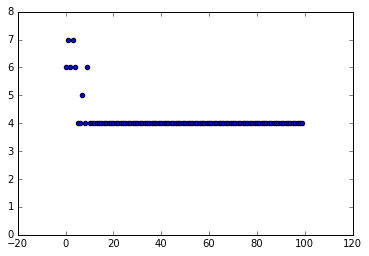

In [222]:
t=TSP(start=0,tolerance=.9,alpha=1.0,beta=1.0,dissipation=0.3,explore=1.0)

routes=[]
for i in xrange(100):
    r,s=t.walk()
    routes.append((r,s))
    t.state=t.update_edges(r,s)
    #if len(t.d)==t.state.number_of_nodes():
        #break
    #print t.edges(data=True)
                  
#print routes
#print t.state.edges(data=True)
print t.d
print t.d_change

s=[i[1] for i in routes]
gen=xrange(len(s))
plt.scatter(gen,s)
_=plt.ylim([0.0,max(s)+1.0])

In [216]:
for r in routes:
    print r

((0, 4, 1, 3, 2), 6.0)
((0, 1, 3, 4, 2), 7.0)
((0, 3, 1, 4, 2), 7.0)
((0, 2, 4, 3, 1), 7.0)
((0, 4, 1, 2, 3), 6.0)
((0, 1, 2, 4, 3), 7.0)
((0, 3, 4, 1, 2), 5.0)
((0, 1, 2, 4, 3), 7.0)
((0, 2, 3, 1, 4), 6.0)
((0, 3, 4, 2, 1), 7.0)
((0, 1, 3, 4, 2), 7.0)
((0, 2, 4, 1, 3), 7.0)
((0, 1, 3, 4, 2), 7.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 3, 4), 4.0)
((0, 2, 1, 

In [74]:
for u,v,d in t.history_s[8].edges(data=True):
    print u,v,d

0 1 {'p': 0.0, 'dist': 0.0}
0 2 {'p': 0.22832961309523808, 'dist': 0.0}
0 3 {'p': 0.0, 'dist': 0.0}
0 4 {'p': 0.0, 'dist': 0.0}
1 2 {'p': 0.013932291666666666, 'dist': 1.0}
1 3 {'p': 0.2251674107142857, 'dist': 1.0}
1 4 {'p': 0.0, 'dist': 2.0}
2 1 {'p': 0.220703125, 'dist': 1.0}
2 3 {'p': 0.0, 'dist': 3.0}
2 4 {'p': 0.0, 'dist': 4.0}
3 1 {'p': 0.015531994047619046, 'dist': 1.0}
3 2 {'p': 0.001953125, 'dist': 0.0}
3 4 {'p': 0.222265625, 'dist': 2.0}
4 1 {'p': 0.007979910714285714, 'dist': 2.0}
4 2 {'p': 0.001953125, 'dist': 0.0}
4 3 {'p': 0.002511160714285714, 'dist': 2.0}


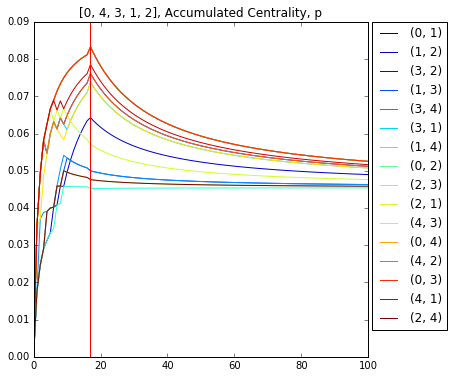

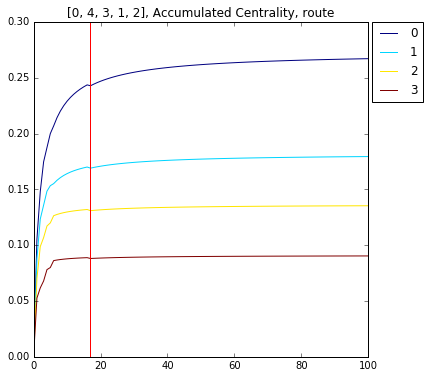

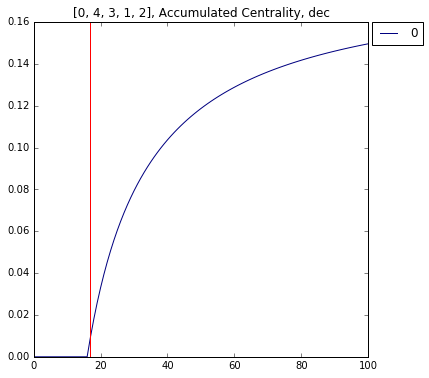

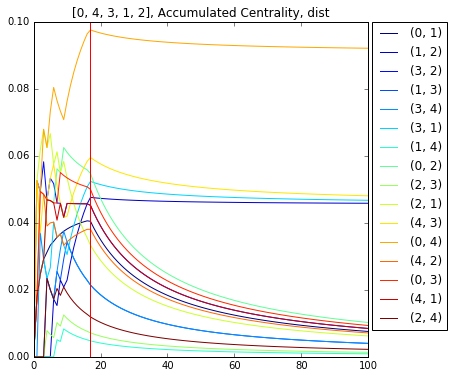

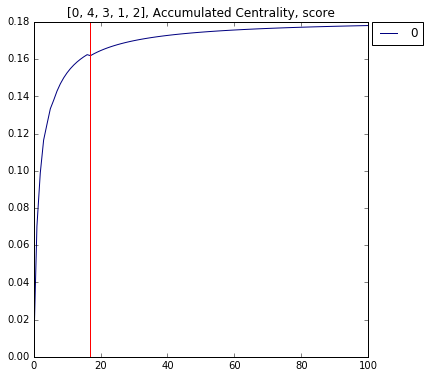

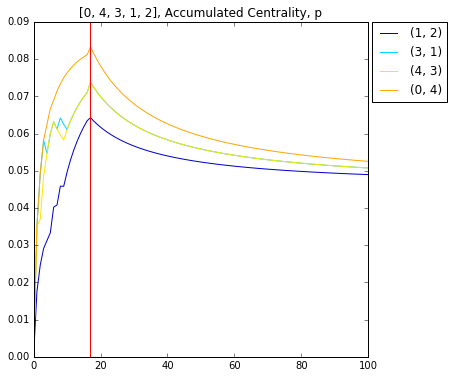

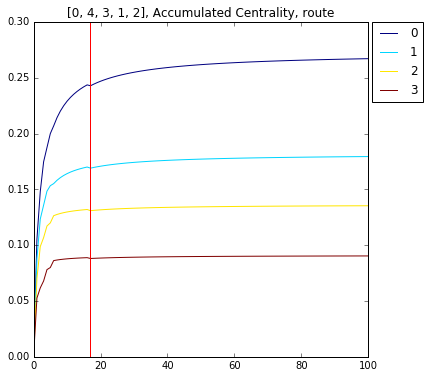

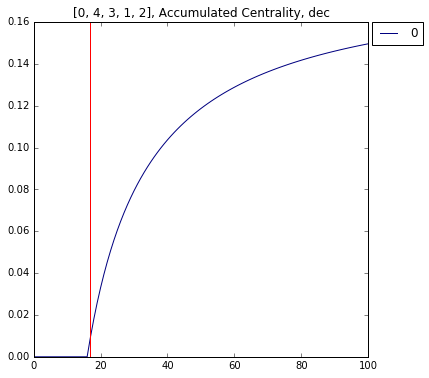

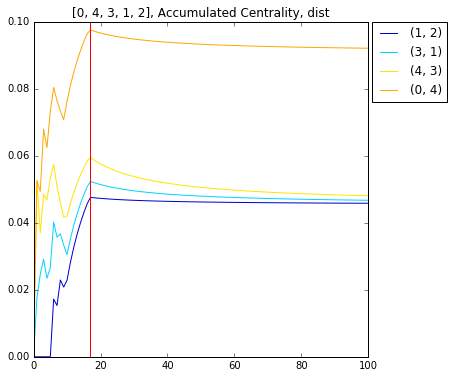

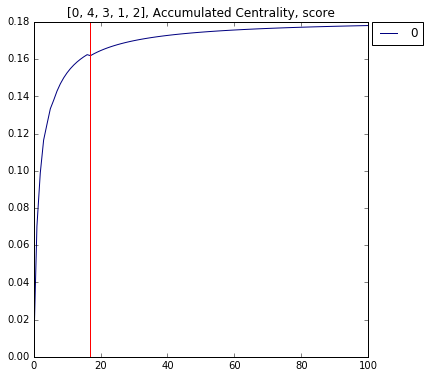

In [223]:
e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        


results={}

for s,kd in t.history_k.iteritems():
    #c=nx.closeness_centrality(kd,normalized=True)
    #c=nx.betweenness_centrality(kd,normalized=True)
    #c=nx.katz_centrality(kd)
    c=nx.out_degree_centrality(kd)
    for k in t.last:
        results.setdefault(k,{})
        for e in t.last[k]:
            n_list=t.last[k][e]
            tc=0.0
            for n in n_list:
                if n in c:
                    tc+=c[n]
                #else:
                    #continue
            
            add=results[k].setdefault(e,[])
            add.append(tc)

#Plotting results
dec_only=False
x=range(t.step)
#print x
cmap=cm.get_cmap('jet')
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if e in e_r:
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))
    
    
dec_only=True
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if e in e_r:
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))

        
        
#print results

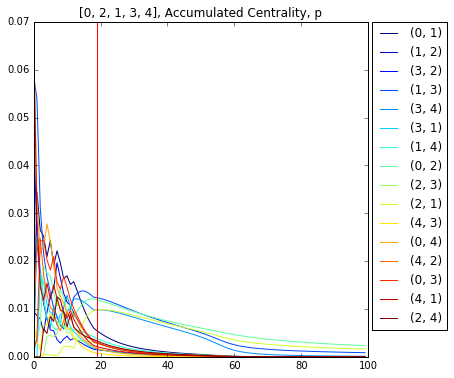

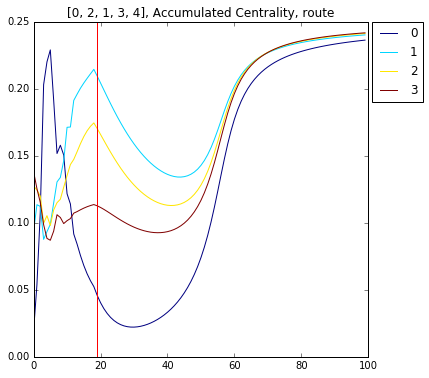

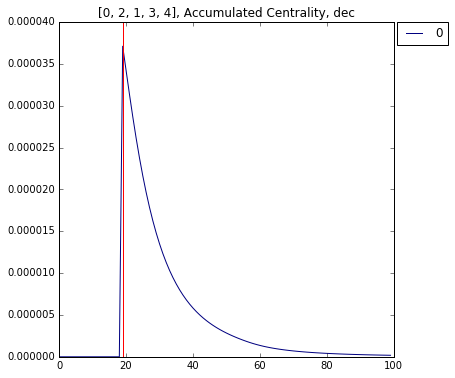

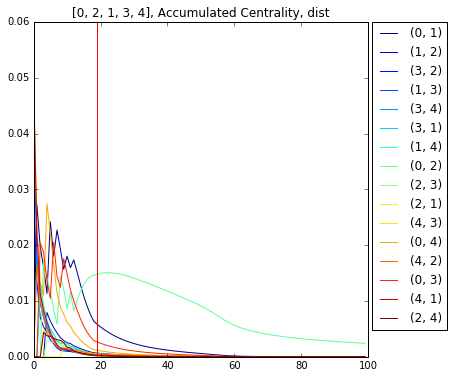

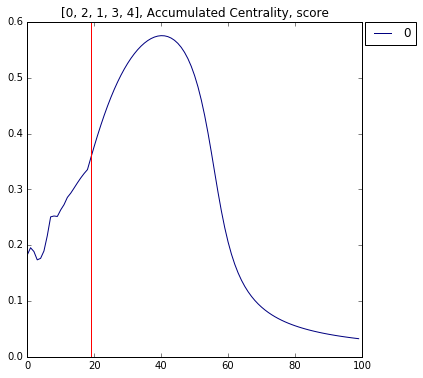

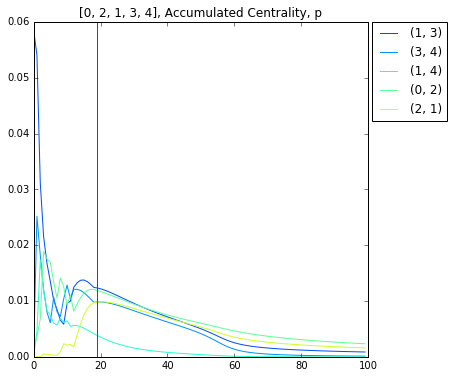

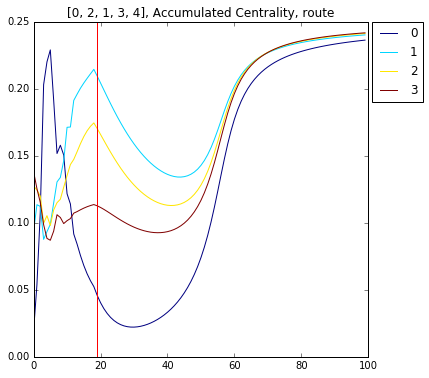

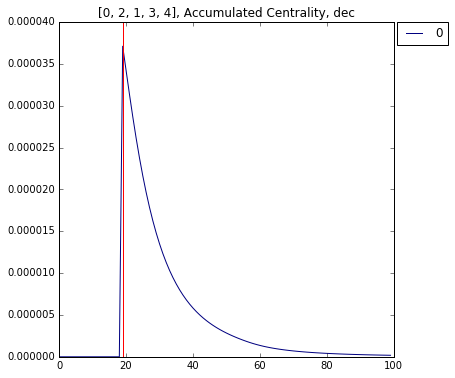

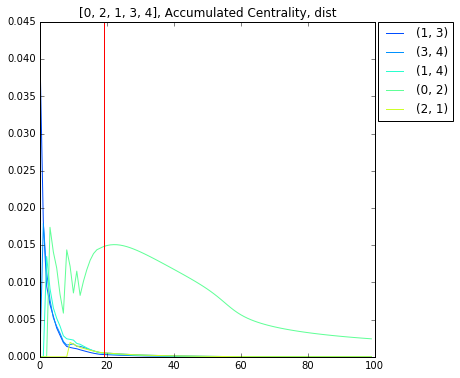

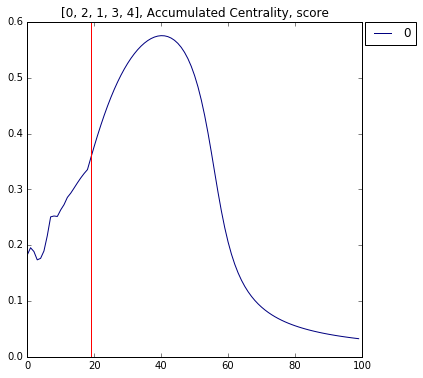

In [218]:
e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        


results={}

for s,kd in t.history_k.iteritems():
    if s == 0:
        continue
    #print s
    (h,c)=nx.hits(kd,max_iter=10000,normalized=True) #(hubs,authorities)

    #c=nx.betweenness_centrality(kd,normalized=True)
    for k in t.last:
        results.setdefault(k,{})
        for e in t.last[k]:
            n_list=t.last[k][e]
            tc=0.0
            for n in n_list:
                if n in c:
                    tc+=c[n]
                #else:
                    #continue
            
            add=results[k].setdefault(e,[])
            add.append(tc)

#Plotting results
dec_only=False
x=range(t.step-1)
#print x
cmap=cm.get_cmap('jet')
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if e in e_r:
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))
    
    
dec_only=True
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if (e in e_r) or (e==(1,4)):
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))

        
        
#print results

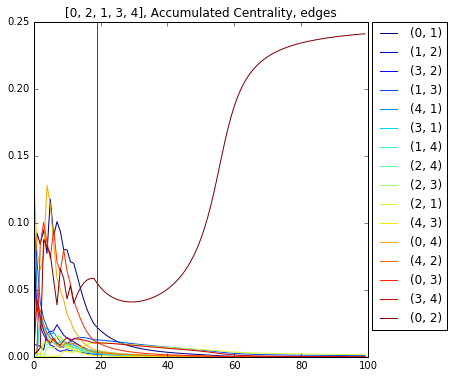

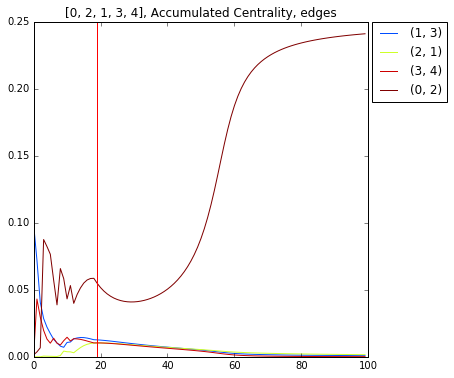

In [83]:
"""
COMPOSITE
"""


e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        
#get composite edge data from 'p','dist', and 'selection'

results={}

for e in t.state.edges():
    results[e]=[]
    


for s,kd in t.history_k.iteritems():
    if s == 0:
        continue
    #print s
    (a,c)=nx.hits(kd,max_iter=10000,normalized=True) #(hubs,authorities)

    #c=nx.betweenness_centrality(kd,normalized=True)
    for e in results.keys():
        tc=0.0
        #contribution from pheromone
        n_list=t.last['p'][e]
        for n in n_list:
            if n in c:
                tc+=c[n]
                
        #contribution from distance
        n_list=t.last['dist'][e]
        for n in n_list:
            if n in c:
                tc+=c[n]
        
        #contribution from route
        n_list=t.last['route'][0]
        for n in n_list:
            if n in c:
                if t.k.node[n]['e']==e:
                    tc+=c[n]

        results[e].append(tc)

#Plotting results
dec_only=False
x=range(t.step-1)
#print x
cmap=cm.get_cmap('jet')
N=len(results.keys())
i=0
plt.figure(figsize=(6,6))
for k,series in results.iteritems():

    
    if N>1:
        c=cmap(float(i)/(N-1))
    else:
        c=cmap(0)
        
    if dec_only:
        if k in e_r:
            plt.plot(x,series,label='{}'.format(k),color=c)

    else:
        plt.plot(x,series,label='{}'.format(k),color=c)
    i+=1
    
for i in xrange(len(t.d_change)):
    #print t.d_change[i]
    plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))

plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
plt.title('{}, Accumulated Centrality, edges'.format(t.d,k))
    
    
dec_only=True
cmap=cm.get_cmap('jet')
N=len(results.keys())
i=0    
plt.figure(figsize=(6,6))
for k,series in results.iteritems(): 
    if N>1:
        c=cmap(float(i)/(N-1))
    else:
        c=cmap(0)
        
    if dec_only:
        if k in e_r:
            plt.plot(x,series,label='{}'.format(k),color=c)

    else:
        plt.plot(x,series,label='{}'.format(k),color=c)
    i+=1
    
for i in xrange(len(t.d_change)):
    #print t.d_change[i]
    plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
plt.title('{}, Accumulated Centrality, edges'.format(t.d,k))

        
        
#print results

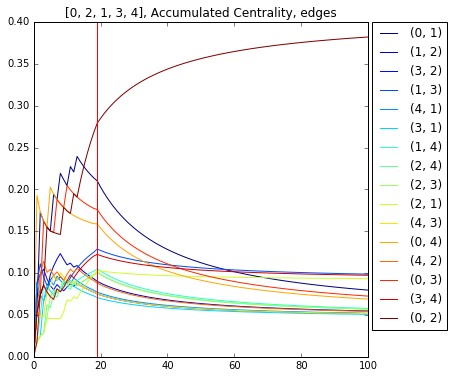

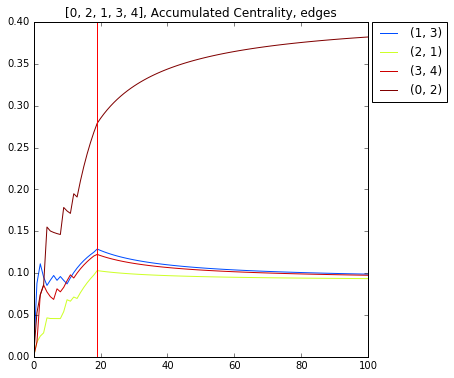

In [98]:
"""
COMPOSITE
"""


e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        
#get composite edge data from 'p','dist', and 'selection'

results={}

for e in t.state.edges():
    results[e]=[]
    


for s,kd in t.history_k.iteritems():
    #if s == 0:
        #continue
    #print s
    #(c,a)=nx.hits(kd,max_iter=10000,normalized=True) #(hubs,authorities)
    c=nx.out_degree_centrality(kd)
    #c=nx.katz_centrality(kd)
    #c=nx.closeness_centrality(kd,normalized=True)
    #c=nx.betweenness_centrality(kd,normalized=True)
    for e in results.keys():
        tc=0.0
        #contribution from pheromone
        n_list=t.last['p'][e]
        for n in n_list:
            if n in c:
                tc+=c[n]
                
        #contribution from distance
        n_list=t.last['dist'][e]
        for n in n_list:
            if n in c:
                tc+=c[n]
        
        #contribution from route
        n_list=t.last['route'][0]
        for n in n_list:
            if n in c:
                if t.k.node[n]['e']==e:
                    tc+=c[n]

        results[e].append(tc)

#Plotting results
dec_only=False
x=range(t.step)
#print x
cmap=cm.get_cmap('jet')
N=len(results.keys())
i=0
plt.figure(figsize=(6,6))
for k,series in results.iteritems():

    
    if N>1:
        c=cmap(float(i)/(N-1))
    else:
        c=cmap(0)
        
    if dec_only:
        if k in e_r:
            plt.plot(x,series,label='{}'.format(k),color=c)

    else:
        plt.plot(x,series,label='{}'.format(k),color=c)
    i+=1
    
for i in xrange(len(t.d_change)):
    #print t.d_change[i]
    plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))

plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
plt.title('{}, Accumulated Centrality, edges'.format(t.d,k))
    
    
dec_only=True
cmap=cm.get_cmap('jet')
N=len(results.keys())
i=0    
plt.figure(figsize=(6,6))
for k,series in results.iteritems(): 
    if N>1:
        c=cmap(float(i)/(N-1))
    else:
        c=cmap(0)
        
    if dec_only:
        if k in e_r:
            plt.plot(x,series,label='{}'.format(k),color=c)

    else:
        plt.plot(x,series,label='{}'.format(k),color=c)
    i+=1
    
for i in xrange(len(t.d_change)):
    #print t.d_change[i]
    plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
plt.title('{}, Accumulated Centrality, edges'.format(t.d,k))

        
        
#print results

In [168]:
t.history_k[s][42]

{46: {'step': 1, 't': 2},
 48: {'step': 1, 't': 2},
 54: {'step': 1, 't': 2},
 56: {'step': 1, 't': 2}}

In [1]:
s=100
alpha=.1
tol=1.0e-6
normalized=True
z={}
nnodes=t.history_k[s].number_of_nodes()
for n in t.history_k[s]:
    if n in t.last['score'][0]:
        score=t.k.node[n]['score']
        z[n]=1.0/score
    else:
        z[n]=0.0
#print z

from math import sqrt

a=nx.adjacency_matrix(t.history_k[s])
#a=nx.to_numpy_matrix(t.history_k[s])
#print a

c=dict.fromkeys(t.history_k[s].nodes(),0.0)
#print c
for k in range(1,20):
    clast=c
    c=dict.fromkeys(clast,0)
    
    for i in c:
        c[i]+=clast[i]
        for j in c:
            #print i,j,
            #print c[i]
            #print clast[i]
            #if a[(j-1,i-1)] and z[j]:
                #print k,j,i, a[(j-1,i-1)]
            #print z[i]
            c[i]+=a[(j-1,i-1)]*z[j]*(alpha**k)
            
    #check convergence
    err = sum([abs(c[n]-clast[n]) for n in c])
    if err<nnodes*tol:
        if normalized:
            # normalize vector
            try:
                tot = 1.0/sqrt(sum(v**2 for v in c.values()))
            # this should never be zero?
            except ZeroDivisionError:
                tot = 1.0
        else:
            tot = 1
        for n in c:
            c[n] *= tot
        #return c
    
    a=a*a
    
#for n in c:
    #print n,c[n],t.history_k[s].node[n]
        

NameError: name 't' is not defined

In [109]:
def fitness_centrality(g,fitness):
    #get nstart fitness values
    nstart={}
    for n in g:
        nstart[n]=0.0
        if n in fitness:
            nstart[n]=fitness[n]
            
    #Get centralities
    c=dict([(n,0) for n in G])
    a=nx.adj_matrix(g)
    for i in range(max_iter):
        clast=c
        c=dict.fromkeys(clast,0)
           
    return c

In [110]:
fit={}
for n in t.last['score'][0]:
    s=t.k.node[n]['score']
    fit[n]=s#1.0/s
    
c=fitness_centrality(kd,fit)
    

In [111]:
print c

{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.13201927760386767, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.01320192776038677, 47: 0.0, 48: 0.01320192776038677, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.01320192776038677, 55: 0.0, 56: 0.01320192776038677, 57: 0.0, 58: 0.0, 59: 0.0013201927760386769, 60: 0.0014522120536425447, 61: 0.0015974332590067994, 62: 0.0004369838088688021, 63: 0.00013201927760386772, 64: 0.00015974332590067993, 65: 4.3698380886880217e-05, 66: 0.15453671882604042, 67: 0.01558569116020791, 68: 0.0, 69: 0.0, 70: 0.0013201927760386769, 71: 0.0, 72: 0.016919085864006977, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0013201927760386769, 79: 0.015613

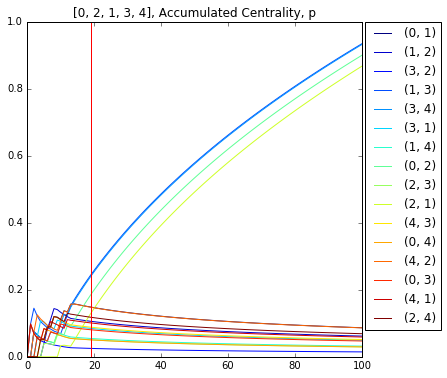

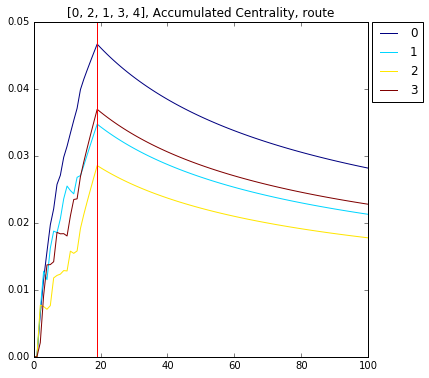

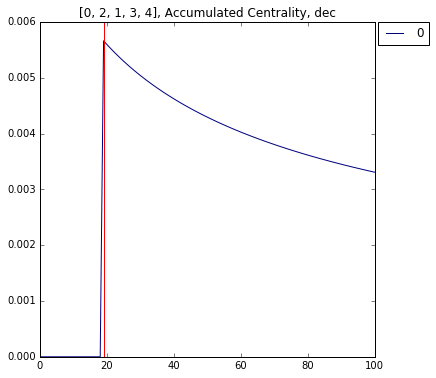

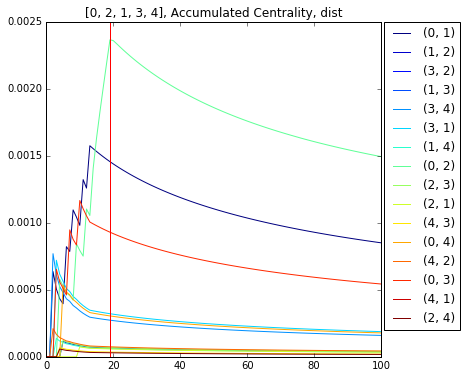

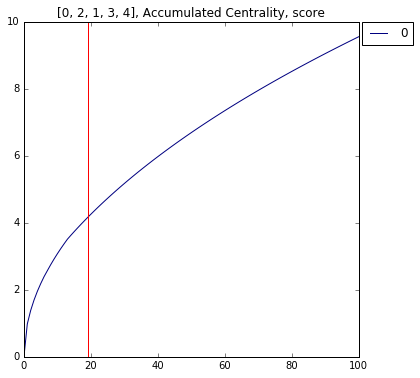

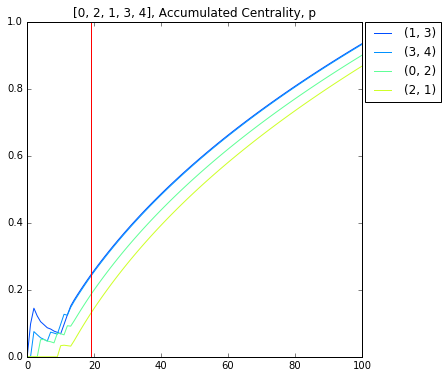

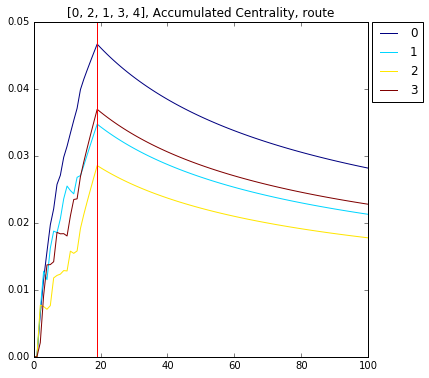

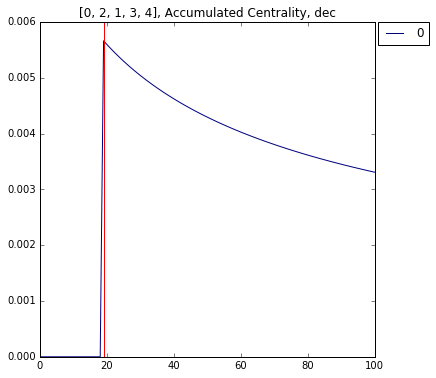

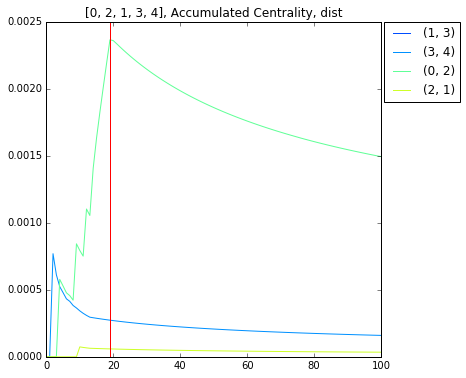

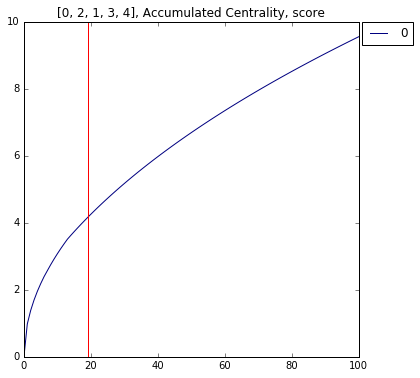

In [113]:
e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        


results={}

for s,kd in t.history_k.iteritems():
    #c=nx.closeness_centrality(kd,normalized=True)
    #c=nx.betweenness_centrality(kd,normalized=True)
    fit={}
    for n in t.last['score'][0]:
        s=t.k.node[n]['score']
        fit[n]=s#1.0/s

    c=fitness_centrality(kd,fit)
    for k in t.last:
        results.setdefault(k,{})
        for e in t.last[k]:
            n_list=t.last[k][e]
            tc=0.0
            for n in n_list:
                if n in c:
                    tc+=c[n]
                #else:
                    #continue
            
            add=results[k].setdefault(e,[])
            add.append(tc)

#Plotting results
dec_only=False
x=range(t.step)
#print x
cmap=cm.get_cmap('jet')
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if e in e_r:
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))
    
    
dec_only=True
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if e in e_r:
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))

        
        
#print results

In [176]:
a=nx.adjacency_matrix(t.history_k[1])
print a**100


In [189]:
b=a**2
print b

  (0, 45)	1
  (0, 41)	1
  (0, 37)	1
  (0, 36)	1
  (0, 35)	1
  (0, 34)	1
  (1, 45)	1
  (1, 41)	1
  (1, 37)	1
  (1, 36)	1
  (1, 35)	1
  (1, 34)	1
  (2, 45)	1
  (2, 41)	1
  (2, 37)	1
  (2, 36)	1
  (2, 35)	1
  (2, 34)	1
  (3, 45)	1
  (3, 41)	1
  (3, 37)	1
  (3, 36)	1
  (3, 35)	1
  (3, 34)	1
  (4, 45)	1
  :	:
  (35, 45)	1
  (35, 53)	2
  (35, 41)	2
  (35, 40)	1
  (36, 55)	1
  (36, 53)	1
  (36, 47)	1
  (36, 45)	1
  (36, 41)	1
  (37, 55)	1
  (37, 53)	1
  (37, 47)	1
  (37, 45)	1
  (38, 55)	1
  (38, 53)	1
  (38, 47)	1
  (38, 45)	1
  (39, 55)	1
  (39, 53)	1
  (39, 47)	1
  (39, 45)	1
  (40, 55)	1
  (40, 53)	1
  (40, 47)	1
  (40, 45)	1


In [190]:
t.history_k[1][41]

{42: {'step': 1, 't': 1}}